# NLP: classification task

## Notes

This notebook is a completely finished text classification work in the sense that this laptop contains all the steps necessary for analyzing and training the model, except for collecting raw data, and produces the result.

Each numbered part is essentially a stand-alone notebook. Thus, it is possible to divide this notebook into three parts.

If you are only interested in the classification model, then skip directly to step 3.

# 1) Dataset creation

## Overview

This part is needed to create a raw dataset for the task of classifying sentences by authorship from the original texts. The output will be a csv file in the format: "sentence", "author".

To create a dataset, works are used (at start of this work):


|Author|Works|
|---------  |-------|
|А.П. Чехов | Collection of stories |
|Ф.М. Достоевский| Collection of selected works |
|Л.Н. Толстой| Most Popular Writings |

## File creation

### Packages import

In [1]:
from typing import List
import random

import glob
from nltk import tokenize, download
import numpy as np
import pandas as pd

It is necessary to tokenize the offer, it is enough to call it on the working machine once:

In [2]:
download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Function for loading and preprocessing text

Let's create a list of sentences, the length of which is more than 5 characters, since shorter ones, most likely, do not carry information useful for attribution. Generally speaking, these sentences can express, and express quite vividly, the writing style of a particular author; however, this is not used in the model.

To improve the performance of the offer tokenizer, some character combinations are replaced. So, the replicas will be separate from the speech of the author in sentences, and the problem with quotes should be solved.

In [3]:
def split_text(filepath: str, min_char: int = 5) -> List[str]:
    
    text = str()
    with open(filepath, 'r', encoding='utf8') as file:
        text = file.read().replace('\n', '. ')
        text = text.replace('.”', '”.').replace('."', '".').replace('?”', '”?').replace('!”', '”!')
        text = text.replace('--', ' ').replace('. . .', '').replace('_', '')
    
    sentences = tokenize.sent_tokenize(text)    
    sentences = [sentence for sentence in sentences if len(sentence) >= min_char]

    return list(sentences)

### Create a sentence| set for each author

In [4]:
chekhov = []
for path in glob.glob('../input/russian-literature/prose/Chekhov/*.txt'):
    chekhov += split_text(path)
    
dostoevsky = []
for path in glob.glob('../input/russian-literature/prose/Dostoevsky/*.txt'):
    dostoevsky += split_text(path)

tolstoy = []
for path in glob.glob('../input/russian-literature/prose/Tolstoy/*.txt'):
    tolstoy += split_text(path)

In [5]:
text_dict = { 'Chekhov': chekhov, 'Dostoevsky': dostoevsky, 'Tolstoy': tolstoy }

for key in text_dict.keys():
    print(key, ':', len(text_dict[key]), ' sentences')

Chekhov : 21860  sentences
Dostoevsky : 117861  sentences
Tolstoy : 92092  sentences


Each list contains 21'860 to 117'861 sentences. In order to have an even distribution of authors in our set, we will limit the set for each, for example, to 20'000 sentences.

### Combining sentences

In [6]:
np.random.seed(1)

max_len = 20_000

names = [chekhov, dostoevsky, tolstoy]

combined = []
for name in names:
    name = np.random.choice(name, max_len, replace = False)
    combined += list(name)

print('Length of combo and internally shuffled list:', len(combined))

Length of combo and internally shuffled list: 60000


### Create a marked list

At this point, it is important to indicate the labels of the authors (their names) in the same order as in the previous step, otherwise the data will simply turn out to be incorrect. So far, a simple regulating mechanism does not come to mind.

In [7]:
labels = ['Chekhov'] * max_len + ['Dostoevsky'] * max_len + ['Tolstoy'] * max_len

print('Length of marked list:', len(labels))

Length of marked list: 60000


The output of the quantity was needed for additional control over the data and their labels. Equality means that every sentence in our dataset will have a label (correct or incorrect - it should have been controlled before).

In [8]:
len(combined) == len(labels)

True

### Randomly shuffle the data

In [9]:
random.seed(3)

zipped = list(zip(combined, labels))
random.shuffle(zipped)
combined, labels = zip(*zipped)

### Exporting the resulting dataset

In [10]:
out_data = pd.DataFrame()
out_data['text'] = combined
out_data['author'] = labels

In [11]:
print(out_data.head())
print(out_data.tail())

                                                text      author
0  Послушайте, доктор, — горячо сказал он, подход...     Chekhov
1  Тогда  я.   обрадовался и страх мой прошел, но...  Dostoevsky
2          (Тянет Ирину за руку, привлекает к себе.)     Chekhov
3                             Так чем могу служить?.     Tolstoy
4                  Хотя, черт его знает… все равно….     Chekhov
                                                    text      author
59995                                   Оба были бледны.  Dostoevsky
59996  Его уже тянуло в рестораны, клубы, на званые о...     Chekhov
59997                      Утро было сырое, стоял туман.  Dostoevsky
59998  Нет; она в своей комнате,   сухо отвечал Мизин...  Dostoevsky
59999  — Лошадь-то чужая, отдать надо... Старуху хоро...     Chekhov


In [12]:
out_data.to_csv('author_data.csv', index=False)

# 2) Dataset preprocessing

Preparing data for use in model training and explore it.

## Importing packages and loading data

In [13]:
import string
import time

import numpy as np
import pandas as pd
from collections import Counter

import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.stem.porter import PorterStemmer

In [14]:
data = pd.read_csv('author_data.csv', encoding='utf8')
print(data.head())

                                                text      author
0  Послушайте, доктор, — горячо сказал он, подход...     Chekhov
1  Тогда  я.   обрадовался и страх мой прошел, но...  Dostoevsky
2          (Тянет Ирину за руку, привлекает к себе.)     Chekhov
3                             Так чем могу служить?.     Tolstoy
4                  Хотя, черт его знает… все равно….     Chekhov


In [15]:
text = list(data['text'].values)
author = list(data['author'].values)

print('Dataset contains {} notes.'.format(len(text)))

Dataset contains 60000 notes.


## Data exploration

Number of sentences for each author:

In [16]:
authors = Counter(author)
authors

Counter({'Chekhov': 20000, 'Dostoevsky': 20000, 'Tolstoy': 20000})

In [17]:
author_names = list(authors.keys())
author_names

['Chekhov', 'Dostoevsky', 'Tolstoy']

Let's look at some sample sentences:

In [18]:
np.random.seed(73)
n = len(text)

for _ in range(5):
    print(text[np.random.randint(0, n)])

— Каштанка!
Он делает визиты и везде говорит, что у него жена и две девочки.
— распутен, лжив и гадок не он один, а мы... «мы люди восьмидесятых годов», «мы вялое, нервное отродье крепостного права», «нас искалечила цивилизация»... Одним словом, мы должны понять, что такой великий человек, как Лаевский, и в падении своем велик; что его распутство, необразованность и нечистоплотность составляют явление естественно-историческое, освященное необходимостью, что причины тут мировые, стихийные и что перед Лаевским надо лампаду повесить, так как он — роковая жертва времени, веяний, наследственности и прочее.
Она упала без чувств ему на руки.
Он предлагает, в виде конечного разрешения вопроса, – разделение человечества на две неравные части.


## Calculating statistics by words:

In [19]:
word_count = np.array([len(sent.split()) for sent in text])
char_count = np.array([len(sent) for sent in text])
ave_length = char_count / word_count

In [20]:
def get_stats(var):    
    print('\t Min: ', np.min(var))
    print('\t Max: ', np.max(var))
    print('\t Average: ', np.mean(var))
    print('\t Median: ', np.median(var))
    print('\t Percentile 1%: ', np.percentile(var, 1))
    print('\t Percentile 95%: ', np.percentile(var, 95))
    print('\t Percentile 99%: ', np.percentile(var, 99))
    print('\t Percentile 99.5%: ', np.percentile(var, 99.5))
    print('\t Percentile 99.9%: ', np.percentile(var, 99.9))

### Word count

In [21]:
print('Word count statistics:')
get_stats(word_count)

Word count statistics:
	 Min:  1
	 Max:  244
	 Average:  15.026033333333332
	 Median:  10.0
	 Percentile 1%:  1.0
	 Percentile 95%:  44.0
	 Percentile 99%:  75.0
	 Percentile 99.5%:  89.0
	 Percentile 99.9%:  132.0


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


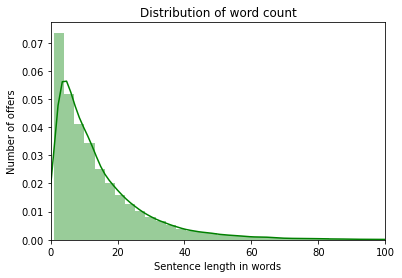

In [22]:
sns.distplot(word_count, kde=True, bins=80, color='green').set_title('Distribution of word count')
plt.xlabel('Sentence length in words')
plt.ylabel('Number of offers')
plt.xlim(0, 100)
plt.savefig('word_count.png')

### Character count

In [23]:
print('Character count statistics:')
get_stats(char_count)

Character count statistics:
	 Min:  5
	 Max:  1710
	 Average:  92.4932
	 Median:  63.0
	 Percentile 1%:  6.0
	 Percentile 95%:  278.0
	 Percentile 99%:  477.0
	 Percentile 99.5%:  572.0
	 Percentile 99.9%:  858.0030000000115


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


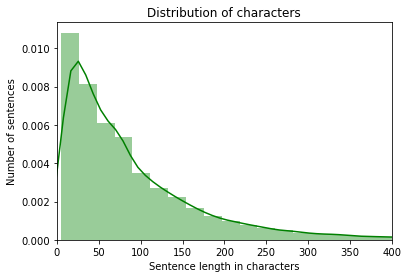

In [24]:
sns.distplot(char_count, kde=True, bins=80, color='green').set_title('Distribution of characters')
plt.xlabel('Sentence length in characters')
plt.ylabel('Number of sentences')
plt.xlim(0, 400)
plt.savefig('char_count.png')

### Average length

In [25]:
print('Average length statistics:')
get_stats(ave_length)

Average length statistics:
	 Min:  2.3333333333333335
	 Max:  35.4
	 Average:  6.098282300821733
	 Median:  6.0
	 Percentile 1%:  3.3333333333333335
	 Percentile 95%:  8.125
	 Percentile 99%:  10.0
	 Percentile 99.5%:  11.0
	 Percentile 99.9%:  13.0


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


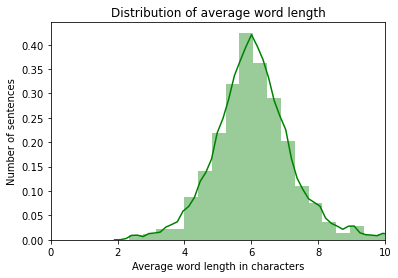

In [26]:
sns.distplot(ave_length, kde=True, bins=80, color='green').set_title('Distribution of average word length')
plt.xlabel('Average word length in characters')
plt.ylabel('Number of sentences')
plt.xlim(0, 10)
plt.savefig('ave_length.png')

## Examining outliers in data

### Extremely long sentences

In [27]:
word_outliers = np.where(word_count > 150)

for i in word_outliers[0][:5]:
    print('Author: {}, Sentence length: {}'.format(author[i], word_count[i]))
    print(text[i], '\n')

Author: Chekhov, Sentence length: 166
Края ее ровные, как бы порезанные, пропитаны жидкой и свернувшейся кровью... Рана проникающая... Произведена она режущим орудием и, как видно из собранных предварительных сведений, кинжалом, ширина которого вполне соответствовала величине раны.. Внутренний осмотр показал поранение правых легкого и плевры, воспаление легкого и кровоизлияние в полость плевры.. Врачи, насколько помню, дали приблизительно такое заключение: a) смерть произошла от малокровия, которое последовало за значительной потерей крови; потеря крови объясняется присутствием на правой стороне груди зияющей раны; b) рану головы следует отнести к тяжким повреждениям, а рану груди к безусловно смертельным; последнюю следует признать за непосредственную причину смерти; c) рана головы нанесена тупым орудием, а рана груди — режущим, и притом, вероятно, обоюдоострым; d) все вышеописанные повреждения не могли быть нанесены собственною рукою умершей и e) покушения на оскорбление женской чест

In [28]:
max_authors = {author : 0 for author in author_names}

for i in word_outliers[0]:
    max_authors[author[i]] += 1

Counter(max_authors)

Counter({'Chekhov': 4, 'Dostoevsky': 1, 'Tolstoy': 18})

### Extremely short

In [29]:
word_outliers = np.where(word_count < 2)

for i in word_outliers[0][:10]:
    print('Sentence length: {}'.format(word_count[i]))
    print(text[i], '\n')

Sentence length: 1
Ирина. 

Sentence length: 1
Ольга. 

Sentence length: 1
(фр.). 

Sentence length: 1
Слышала. 

Sentence length: 1
Воды!... 

Sentence length: 1
Каштанка!. 

Sentence length: 1
Степушка!. 

Sentence length: 1
Ужас! 

Sentence length: 1
Миша! 

Sentence length: 1
неестественно. 



## Exploring symbols

Let's create a dictionary showing the number of dataset inclusions for each character.

In [30]:
text_string = ''
for sents in text:
    text_string += sents.lower()

char_cnt = Counter(text_string)
print(char_cnt)
print(len(char_cnt), 'unusual symbols in data.')

Counter({' ': 885133, 'о': 485392, 'е': 370495, 'а': 354225, 'и': 286585, 'н': 277973, 'т': 264673, 'с': 225058, 'л': 208520, 'в': 196476, 'р': 176961, 'к': 147094, 'д': 135388, 'м': 135373, ',': 125431, 'у': 122884, 'п': 112368, '.': 98145, 'я': 96563, 'ь': 87320, 'г': 81420, 'ы': 79514, 'б': 76006, 'ч': 72123, 'з': 70834, 'ж': 48782, 'й': 47280, 'ш': 39797, 'х': 37008, 'ю': 27763, 'ц': 13891, 'э': 13045, 'щ': 12713, '-': 12678, '—': 11654, '–': 11245, '!': 10146, '\xa0': 7880, '?': 7616, 'ф': 7369, ';': 5097, 'e': 4352, ':': 4297, '…': 3625, 'i': 2917, '«': 2867, '»': 2830, 'a': 2254, ')': 2171, '(': 2140, 's': 2131, 'n': 2124, 'r': 1861, 'ё': 1829, 'o': 1763, 't': 1702, '1': 1679, 'u': 1631, '2': 1466, 'm': 1457, 'l': 1439, '"': 1271, '3': 1258, 'ъ': 1186, 'c': 953, 'd': 896, '8': 774, 'v': 721, 'p': 704, '6': 621, '4': 588, '[': 587, ']': 583, '5': 527, '0': 507, '7': 480, '9': 461, 'h': 436, '&': 413, '#': 412, 'x': 392, 'b': 354, 'f': 312, "'": 308, '*': 295, 'q': 280, 'g': 260, 

All symbols used:

In [31]:
print(list(char_cnt.keys()))

['п', 'о', 'с', 'л', 'у', 'ш', 'а', 'й', 'т', 'е', ',', ' ', 'д', 'к', 'р', '—', 'г', 'я', 'ч', 'з', 'н', 'х', 'и', 'в', '.', 'б', 'м', '(', ')', 'ж', 'ь', '?', '…', 'щ', 'ы', 'ф', '«', '\xa0', ';', '»', 'ю', 'ц', '–', ':', 'э', '!', '-', 'ё', '8', '4', '6', 'i', '1', 'ъ', '"', 'm', 'l', 'e', 'b', 'o', 'u', 'r', 'n', '*', '[', '2', '9', ']', 'à', "'", 'f', 'a', 't', '5', '3', '7', 'v', '„', '“', 'c', 'h', 'p', 's', '&', '#', 'd', 'g', 'x', 'q', '́', '\x7f', '{', '}', '0', 'y', 'z', '’', 'ê', 'j', 'é', 'ó', 'è', 'ô', '̀', 'w', '/', '№', 'á', 'k', 'ü', 'â', '\t', '>', 'ç', '<', 'ö', '”', '`', '°', 'ï', '\x01', 'і', 'î', '‑', 'ї', '%', 'ý', 'ò', '=', 'û']


Among them there are many that do not belong to the standard ones, such as punctuation or Cyrillic characters. Let's highlight those sentences in which they occur.

In [32]:
accented_chars = ['f', 'u', 'r', 's', 'i', 'c', 'h', '́', 'n', 'd', 'p', 'e', 'a', 't', 'o', 'l', 'x', 'm', 'j', 'é', 'ô', 'v', 'q', 'ê', 'g', 'b', 'k', 'y', 'à', 'і', 'z', 'w', 'è', 'ó', 'ö', '°', 'ç', 'ï', 'á', 'ü', 'ù', 'û', 'î', 'ѣ', 'â']

accented_text = []
for i in range(len(text)):
    for j in text[i]:
        if j in accented_chars:
            accented_text.append(i)
        
accented_text = list(set(accented_text))
 
print(len(accented_text), 'sentences contains unusual symbols.')

1343 sentences contains unusual symbols.


In [33]:
for i in accented_text[:10]:
    print('Sentence number {}: '.format(i))
    print(text[i], '\n')

Sentence number 24584: 
Я вас довезу..    Перед тем как уехать, уже в передней Нехлюдова встретил лакей с запиской к нему от Mariette:. 

Sentence number 57358: 
Евгений Федорович хотя и моветон note 2, между нами говоря, но сведущий; на него вполне можно положиться. 

Sentence number 40987: 
— И таким образом уничтожив молодого человека, Анна Павловна обратилась к Билибину, который в другом кружке, подобрав кожу и, видимо, сбираясь распустить ее, чтобы сказать un mot, говорил об австрийцах..      — Je trouve que c'est charmant! 

Sentence number 32807: 
слова  каким-то  раздавленным,  дребезжащим   голосом;   слово   prйfйrable,. 

Sentence number 41001: 
— Voudrez vous bien me dire &#224; pr&#233;sent, &#224; qui j'ai l'honneur de parler aussi agr&#233;ablement au lieu de rester &#224; l'ambulance avec la balle de ce fou dans le &#231;orps[240]..      Пьер отвечал, что не может сказать своего имени, и, покраснев, начал было, пытаясь выдумать имя, говорить о причинах, по которым он не

Based on the above research proposals, we can say that our data is quite suitable for analysis. The only thing is that you need to remove the indented blocks and some invalid characters that are artifacts of the original text.

## Data preparation

This is exactly where we remove the unacceptable uninformative characters.

In [34]:
text = [excerpt.replace('\xa0', '').replace('\x7f', '') for excerpt in text]

And big blocks of indentation.

In [35]:
ctr = 0
for excerpt in text:
    if '  ' in excerpt:
        ctr += 1

print(ctr, 'occurrences of large blocks of indentation.')

9033 occurrences of large blocks of indentation.


In [36]:
new_text = []
for excerpt in text:
    while '  ' in excerpt:
        excerpt = excerpt.replace('  ',' ')
    new_text.append(excerpt)

text = new_text
print(len(text))

60000


Remove punctuation and convert all letters of the sentence to lowercase.

In [37]:
normed_text = []

for sent in text:
    new = sent.lower()
    new = new.translate(str.maketrans('','', string.punctuation))
    new = new.replace('“', '').replace('”', '') # english quotes
    new = new.replace('‟', '').replace('”', '') # french quotes
    new = new.replace('«', '').replace('»', '') # christmas tree quotes
    new = new.replace('—', '').replace('–', '') # em dash
    new = new.replace('(', '').replace(')', '')
    new = new.replace('…', '') # ellipsis as one character
    
    normed_text.append(new)
    
print(normed_text[0:5])
print(len(normed_text))

['послушайте доктор  горячо сказал он подходя к кирилову', 'тогда я обрадовался и страх мой прошел но я ошибался как и узнал потом к моему', 'тянет ирину за руку привлекает к себе', 'так чем могу служить', 'хотя черт его знает все равно']
60000


## Save the prepared data

In [38]:
data['text'] = normed_text

data.to_csv('preprocessed_data.csv', index=False)

# Analysys

Teaching and learning models.

## Importing packages and loading pre-prepared data

In [39]:
from typing import List

import numpy as np
import pandas as pd
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import string
import time

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.preprocessing import LabelBinarizer

import keras
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Dropout, Embedding
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers.merge import concatenate
from keras.optimizers import Adam
from keras.preprocessing.text import one_hot
from keras.callbacks import ModelCheckpoint 

from scipy import stats

In [40]:
data = pd.read_csv("preprocessed_data.csv", encoding='utf8')
print(data.head())

                                                text      author
0  послушайте доктор  горячо сказал он подходя к ...     Chekhov
1  тогда я обрадовался и страх мой прошел но я ош...  Dostoevsky
2              тянет ирину за руку привлекает к себе     Chekhov
3                               так чем могу служить     Tolstoy
4                      хотя черт его знает все равно     Chekhov


In [41]:
normed_text = list(data['text'])
author = list(data['author'])

authors_names = list(Counter(author).keys())
authors_count = len(authors_names)

normed_text = [str(i) for i in normed_text]

## Section with statistics and output functions

In [42]:
def plot_confusion_matrix(cm, classes: List[str],
                          normalize: bool = False,
                          title: str = 'Confusion matrix',
                          cmap = plt.cm.Greens):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Unnormalized confusion matrix')

    print(cm)
       
    df_cm = pd.DataFrame(cm, index = classes,
                  columns = classes)
    sns.heatmap(df_cm, annot=True, cmap = cmap)
    plt.ylabel('Right author')
    plt.xlabel('Predicted author')
    plt.title(title)

In [43]:
def plot_history_of_accurancy(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model\'s accurancy')
    plt.ylabel('accurancy')
    plt.xlabel('epochs')
    plt.legend(['teaching data', 'test data'], loc='upper left')

In [44]:
def plot_history_of_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model\'s error')
    plt.ylabel('error')
    plt.xlabel('epochs')
    plt.legend(['teaching data', 'test data'], loc='upper left')

## Preparing data for direct use

### We select the training and test set

In [45]:
text_train, text_test, author_train, author_test = train_test_split(normed_text, author, test_size=0.2, random_state=5)

In [46]:
print(np.shape(text_train))
print(np.shape(text_test))
print(np.shape(author_train))
print(np.shape(author_test))

(48000,)
(12000,)
(48000,)
(12000,)


### Create n-gram sequences

In [47]:
def create_n_grams(excerpt_list: List[str], n: int, vocab_size: int, seq_size: int):
    n_gram_list = []

    for excerpt in excerpt_list:
        excerpt = excerpt.replace(" ", "")

        n_grams = [excerpt[i:i + n] for i in range(len(excerpt) - n + 1)]

        new_string = " ".join(n_grams)

        hot = one_hot(new_string, round(vocab_size * 1.3))

        hot_len = len(hot)
        if hot_len >= seq_size:
            hot = hot[0:seq_size]
        else:
            diff = seq_size - hot_len
            extra = [0]*diff
            hot = hot + extra

        n_gram_list.append(hot)
    
    n_gram_array = np.array(n_gram_list)
    
    return n_gram_array

In [48]:
def get_vocab_size(excerpt_list: List[str], n: int, seq_size: int) -> int:
    n_gram_list = []

    for excerpt in excerpt_list:
        excerpt = excerpt.replace(" ", "")
   
        n_grams = [excerpt[i:i + n] for i in range(len(excerpt) - n + 1)]

        gram_len = len(n_grams)
        if gram_len >= seq_size:
            n_grams = n_grams[0:seq_size]
        else:
            diff = seq_size - gram_len
            extra = [0]*diff
            n_grams = n_grams + extra
        
        n_gram_list.append(n_grams)
    
    n_gram_list = list(np.array(n_gram_list).flat)
    
    n_gram_cnt = Counter(n_gram_list)
    vocab_size = len(n_gram_cnt)
    
    return vocab_size

Determine the size of the dictionary for n from 1 to 3 inclusive:

In [49]:
vocab_sizes = []
for i in range(1, 4):
    vocab_sizes.append(get_vocab_size(text_train, i, 350))
    print('Size for n =', i, 'is:', vocab_sizes[i - 1])

Size for n = 1 is: 96
Size for n = 2 is: 2840
Size for n = 3 is: 23854


And create lists of n-grams:

In [50]:
gram1_train = create_n_grams(text_train, 1, vocab_sizes[0], 350)
gram2_train = create_n_grams(text_train, 2, vocab_sizes[1], 350)
gram3_train = create_n_grams(text_train, 3, vocab_sizes[2], 350)

In [51]:
gram1_test = create_n_grams(text_test, 1, vocab_sizes[0], 350)
gram2_test = create_n_grams(text_test, 2, vocab_sizes[1], 350)
gram3_test = create_n_grams(text_test, 3, vocab_sizes[2], 350)

In [52]:
print(np.shape(gram1_train))
print(np.shape(gram2_train))
print(np.shape(gram3_train))

print(np.shape(gram1_test))
print(np.shape(gram2_test))
print(np.shape(gram3_test))

(48000, 350)
(48000, 350)
(48000, 350)
(12000, 350)
(12000, 350)
(12000, 350)


Определим максимальное значение n-грамм, что будет использовано для создания сети.

In [53]:
max_1gram = np.max(gram1_train)
max_2gram = np.max(gram2_train)
max_3gram = np.max(gram3_train)

print('Max value for 1-gramms: ', max_1gram)
print('Max value for bigramms: ', max_2gram)
print('Max value for trigramms: ', max_3gram)

Max value for 1-gramms:  124
Max value for bigramms:  3690
Max value for trigramms:  31008


## Vectorization

In [54]:
processed_train = text_train
processed_test = text_test

print(processed_train[0:5])

['татьяна', ' сухо сказал он ему и кликнув кучера принялся выпрастывать лошадей ', 'я был там и нашел две трети людей и лошадей перебитыми два орудия исковерканными и прикрытия никакого князь багратион и тушин одинаково упорно смотрели теперь на сдержанно и взволнованно говорившего болконского и ежели ваше сиятельство позволите мне высказать свое мнение продолжал он то успехом дня мы обязаны более всего действию этой батареи и геройской стойкости капитана тушина с его ротой сказал князь андрей и не ожидая ответа тотчас же встал и отошел от стола князь багратион посмотрел на тушина и видимо не желая выказать недоверия к резкому суждению болконского и вместе с тем чувствуя себя не в состоянии вполне верить ему наклонил голову и сказал тушину что он может идти', 'и проказникто я и забавникто я и перепугалто я их ну такое сладчайшее что самому стыдно стало так что стоишь да со страхом и думаешь как такого грешника такое место святое на себе держать может', 'живо']


In [55]:
vectorizer = TfidfVectorizer(strip_accents = 'unicode', min_df = 6)
vectorizer.fit(processed_train)

print('Dictionary size: ', len(vectorizer.vocabulary_))

words_train = vectorizer.transform(processed_train)
words_test = vectorizer.transform(processed_test)

Dictionary size:  11217


In [56]:
author_lb = LabelBinarizer()

author_lb.fit(author_train)
author_train_hot = author_lb.transform(author_train)
author_test_hot = author_lb.transform(author_test)

## Model implementation

https://machinelearningmastery.com/develop-n-gram-multichannel-convolutional-neural-network-sentiment-analysis/

In [57]:
def define_model(input_len: int, output_size: int, vocab_size : int, embedding_dim: int, verbose: bool = True,
                drop_out_pct: float = 0.25, conv_filters: int = 500, activation_fn: str = 'relu', pool_size: int = 2, learning: float = 0.0001):
    inputs1 = Input(shape=(input_len,))
    embedding1 = Embedding(vocab_size, embedding_dim)(inputs1)
    drop1 = Dropout(drop_out_pct)(embedding1)
    conv1 = Conv1D(filters=conv_filters, kernel_size=3, activation=activation_fn)(drop1)
    pool1 = MaxPooling1D(pool_size=pool_size)(conv1)
    flat1 = Flatten()(pool1)
    
    inputs2 = Input(shape=(input_len,))
    embedding2 = Embedding(vocab_size, embedding_dim)(inputs2)
    drop2 = Dropout(drop_out_pct)(embedding2)
    conv2 = Conv1D(filters=conv_filters, kernel_size=4, activation=activation_fn)(drop2)
    pool2 = MaxPooling1D(pool_size=pool_size)(conv2)
    flat2 = Flatten()(pool2)
    
    inputs3 = Input(shape=(input_len,))
    embedding3= Embedding(vocab_size, embedding_dim)(inputs3)
    drop3 = Dropout(drop_out_pct)(embedding3)
    conv3 = Conv1D(filters=conv_filters, kernel_size=5, activation=activation_fn)(drop3)
    pool3 = MaxPooling1D(pool_size=pool_size)(conv3)
    flat3 = Flatten()(pool3)
    
    merged = concatenate([flat1, flat2, flat3])
    
    output = Dense(output_size, activation='softmax')(merged)
    
    model = Model(inputs=[inputs1, inputs2, inputs3], outputs=output)
    
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=learning), metrics=['accuracy'])
    
    if verbose:
        print(model.summary())
        
    return model

## Calculations

In [58]:
gram1_model = define_model(350, authors_count, max_1gram + 1, 26)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 350)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 350)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 350)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 350, 26)      3250        input_1[0][0]                    
______________________________________________________________________________________________

In [59]:
gram1_model_history = gram1_model.fit([gram1_train, gram1_train, gram1_train], author_train_hot, epochs=10, batch_size=32, 
                verbose = 1, validation_split = 0.2)

Epoch 1/10
1200/1200 [==============================] - 23s 16ms/step - loss: 1.0952 - accuracy: 0.3681 - val_loss: 1.0670 - val_accuracy: 0.4332
Epoch 2/10
1200/1200 [==============================] - 19s 16ms/step - loss: 1.0593 - accuracy: 0.4413 - val_loss: 1.0445 - val_accuracy: 0.4552
Epoch 3/10
1200/1200 [==============================] - 18s 15ms/step - loss: 1.0259 - accuracy: 0.4734 - val_loss: 1.0383 - val_accuracy: 0.4636
Epoch 4/10
1200/1200 [==============================] - 19s 15ms/step - loss: 1.0031 - accuracy: 0.4948 - val_loss: 1.0405 - val_accuracy: 0.4572
Epoch 5/10
1200/1200 [==============================] - 18s 15ms/step - loss: 0.9782 - accuracy: 0.5166 - val_loss: 1.0228 - val_accuracy: 0.4731
Epoch 6/10
1200/1200 [==============================] - 18s 15ms/step - loss: 0.9544 - accuracy: 0.5364 - val_loss: 1.0340 - val_accuracy: 0.4715
Epoch 7/10
1200/1200 [==============================] - 18s 15ms/step - loss: 0.9282 - accuracy: 0.5531 - val_loss: 1.0183 -

In [60]:
gram2_model = define_model(350, authors_count, max_2gram + 1, 300)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 350)]        0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 350)]        0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 350)]        0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 350, 300)     1107300     input_4[0][0]                    
____________________________________________________________________________________________

In [61]:
gram2_model_history = gram2_model.fit([gram2_train, gram2_train, gram2_train], author_train_hot, epochs=10, batch_size=32, 
                verbose = 1, validation_split = 0.2)

Epoch 1/10
1200/1200 [==============================] - 85s 70ms/step - loss: 1.0910 - accuracy: 0.3865 - val_loss: 1.0041 - val_accuracy: 0.5034
Epoch 2/10
1200/1200 [==============================] - 84s 70ms/step - loss: 0.9479 - accuracy: 0.5474 - val_loss: 0.9445 - val_accuracy: 0.5407
Epoch 3/10
1200/1200 [==============================] - 84s 70ms/step - loss: 0.8497 - accuracy: 0.6096 - val_loss: 0.9126 - val_accuracy: 0.5587
Epoch 4/10
1200/1200 [==============================] - 85s 71ms/step - loss: 0.7710 - accuracy: 0.6575 - val_loss: 0.9052 - val_accuracy: 0.5682
Epoch 5/10
1200/1200 [==============================] - 85s 71ms/step - loss: 0.6832 - accuracy: 0.7104 - val_loss: 0.9138 - val_accuracy: 0.5672
Epoch 6/10
1200/1200 [==============================] - 84s 70ms/step - loss: 0.6142 - accuracy: 0.7477 - val_loss: 0.9259 - val_accuracy: 0.5717
Epoch 7/10
1200/1200 [==============================] - 84s 70ms/step - loss: 0.5425 - accuracy: 0.7905 - val_loss: 0.9432 -

In [62]:
t0 = time.time()
gram3_model = define_model(350, authors_count, max_3gram + 1, 600)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 350)]        0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 350)]        0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            [(None, 350)]        0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 350, 600)     18605400    input_7[0][0]                    
____________________________________________________________________________________________

In [63]:
gram3_model_history = gram3_model.fit([gram3_train, gram3_train, gram3_train], author_train_hot, epochs=10, batch_size=32, 
                verbose=1, validation_split=0.2)
t1 = time.time()

Epoch 1/10
1200/1200 [==============================] - 1108s 922ms/step - loss: 1.0901 - accuracy: 0.3860 - val_loss: 0.8907 - val_accuracy: 0.5893
Epoch 2/10
1200/1200 [==============================] - 1122s 935ms/step - loss: 0.7798 - accuracy: 0.6530 - val_loss: 0.8179 - val_accuracy: 0.6210
Epoch 3/10
1200/1200 [==============================] - 1125s 937ms/step - loss: 0.5688 - accuracy: 0.7699 - val_loss: 0.8115 - val_accuracy: 0.6367
Epoch 4/10
1200/1200 [==============================] - 1130s 942ms/step - loss: 0.4127 - accuracy: 0.8476 - val_loss: 0.8708 - val_accuracy: 0.6275
Epoch 5/10
1200/1200 [==============================] - 1129s 940ms/step - loss: 0.2801 - accuracy: 0.9103 - val_loss: 0.9629 - val_accuracy: 0.6288
Epoch 6/10
1200/1200 [==============================] - 1138s 949ms/step - loss: 0.1740 - accuracy: 0.9497 - val_loss: 1.0982 - val_accuracy: 0.6216
Epoch 7/10
1200/1200 [==============================] - 1141s 950ms/step - loss: 0.1140 - accuracy: 0.9676

## 3-gramm first model statistics

In [64]:
author_pred1 = gram3_model.predict([gram3_test, gram3_test, gram3_test])

t2 = time.time()

author_pred1 = author_lb.inverse_transform(author_pred1)

accuracy = accuracy_score(author_test, author_pred1)
precision, recall, f1, support = score(author_test, author_pred1)
ave_precision = np.average(precision, weights = support/np.sum(support))
ave_recall = np.average(recall, weights = support/np.sum(support))
ave_f1 = np.average(f1, weights = support/np.sum(support))
confusion = confusion_matrix(author_test, author_pred1, labels=authors_names)
    
print('Accurancy:', accuracy)
print('Average Precision:', ave_precision)
print('Average Recall:', ave_recall)
print('Average F1 Score:', ave_f1)
print('Learning time:', (t1 - t0), 'seconds')
print('Prediction time:', (t2 - t1), 'seconds')
print('Confusion matrix:\n', confusion)

Accurancy: 0.5996666666666667
Average Precision: 0.5999105258100699
Average Recall: 0.5996666666666667
Average F1 Score: 0.599433375195788
Learning time: 11378.534809112549 seconds
Prediction time: 50.31611776351929 seconds
Confusion matrix:
 [[2543  729  781]
 [ 869 2218  818]
 [ 883  724 2435]]


Normalized confusion matrix
[[0.62743647 0.17986677 0.19269677]
 [0.22253521 0.56798976 0.20947503]
 [0.21845621 0.17911925 0.60242454]]


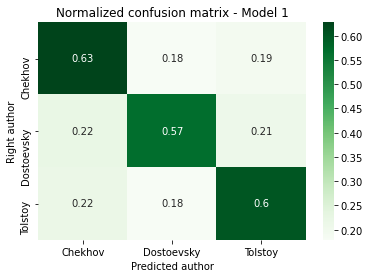

In [65]:
plot_confusion_matrix(confusion, classes=authors_names, \
                      normalize=True, title='Normalized confusion matrix - Model 1')

plt.savefig('confusion_model1.png')

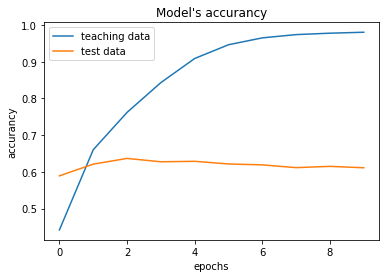

In [66]:
plot_history_of_accurancy(gram3_model_history)
plt.savefig('accurancy_model1.png')

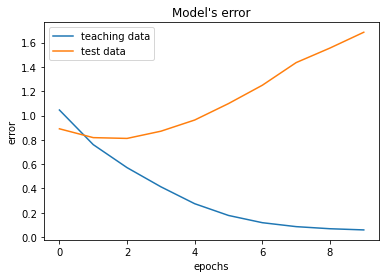

In [67]:
plot_history_of_loss(gram3_model_history)
plt.savefig('loss_model1.png')

In [68]:
keras.utils.plot_model(gram3_model, 'gram3_model1_arh.png')

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


The trigram model showed the best results in terms of accuracy, so you should choose it as the main one.

The improved version should only be trained for 5 epochs, because the graph shows a plateau and even a decline in model accuracy after this point.

## Improvement

Retraining the trigram model with the addition of an additional channel.

In [69]:
def define_model2(input_len: int, output_size: int, vocab_size: int, embedding_dim: int, verbose: bool = True,
                drop_out_pct: float = 0.25, conv_filters: int = 500, activation_fn: str = 'relu', pool_size:int = 2, learning: float = 0.0001):
    
    inputs1 = Input(shape=(input_len,))
    embedding1 = Embedding(vocab_size, embedding_dim)(inputs1)
    drop1 = Dropout(drop_out_pct)(embedding1)
    conv1 = Conv1D(filters=conv_filters, kernel_size=3, activation=activation_fn)(drop1)
    pool1 = MaxPooling1D(pool_size=pool_size)(conv1)
    flat1 = Flatten()(pool1)
    
    inputs2 = Input(shape=(input_len,))
    embedding2 = Embedding(vocab_size, embedding_dim)(inputs2)
    drop2 = Dropout(drop_out_pct)(embedding2)
    conv2 = Conv1D(filters=conv_filters, kernel_size=4, activation=activation_fn)(drop2)
    pool2 = MaxPooling1D(pool_size=pool_size)(conv2)
    flat2 = Flatten()(pool2)

    inputs3 = Input(shape=(input_len,))
    embedding3= Embedding(vocab_size, embedding_dim)(inputs3)
    drop3 = Dropout(drop_out_pct)(embedding3)
    conv3 = Conv1D(filters=conv_filters, kernel_size=5, activation=activation_fn)(drop3)
    pool3 = MaxPooling1D(pool_size=pool_size)(conv3)
    flat3 = Flatten()(pool3)
    
    inputs4 = Input(shape=(input_len,))
    embedding4 = Embedding(vocab_size, embedding_dim)(inputs4)
    drop4 = Dropout(drop_out_pct)(embedding4)
    conv4 = Conv1D(filters=conv_filters, kernel_size=6, activation=activation_fn)(drop4)
    pool4 = MaxPooling1D(pool_size=pool_size)(conv4)
    flat4 = Flatten()(pool4)
    
    merged = concatenate([flat1, flat2, flat3, flat4])
    
    output = Dense(output_size, activation='softmax')(merged)
    
    model = Model(inputs = [inputs1, inputs2, inputs3, inputs4], outputs = output)
    
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=learning), metrics=['accuracy'])
    
    if verbose:
        print(model.summary())
        
    return model

In [70]:
t0 = time.time()
gram3_model2 = define_model2(350, authors_count, max_3gram + 1, 600)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 350)]        0                                            
__________________________________________________________________________________________________
input_11 (InputLayer)           [(None, 350)]        0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 350)]        0                                            
__________________________________________________________________________________________________
input_13 (InputLayer)           [(None, 350)]        0                                            
____________________________________________________________________________________________

In [71]:
gram3_model2_history = gram3_model2.fit([gram3_train, gram3_train, gram3_train, gram3_train], author_train_hot, epochs=5, batch_size=32, 
                verbose=1, validation_split=0.2)
t1 = time.time()

Epoch 1/5
1200/1200 [==============================] - 1570s 1s/step - loss: 1.0875 - accuracy: 0.3934 - val_loss: 0.8853 - val_accuracy: 0.5809
Epoch 2/5
1200/1200 [==============================] - 1535s 1s/step - loss: 0.7500 - accuracy: 0.6665 - val_loss: 0.8046 - val_accuracy: 0.6256
Epoch 3/5
1200/1200 [==============================] - 1543s 1s/step - loss: 0.5314 - accuracy: 0.7890 - val_loss: 0.8213 - val_accuracy: 0.6309
Epoch 4/5
1200/1200 [==============================] - 1550s 1s/step - loss: 0.3560 - accuracy: 0.8778 - val_loss: 0.8906 - val_accuracy: 0.6254
Epoch 5/5
1200/1200 [==============================] - 1543s 1s/step - loss: 0.2158 - accuracy: 0.9371 - val_loss: 1.0399 - val_accuracy: 0.6186


In [72]:
author_pred2 = gram3_model2.predict([gram3_test, gram3_test, gram3_test, gram3_test])

t2 = time.time()

author_pred2 = author_lb.inverse_transform(author_pred2)

accuracy = accuracy_score(author_test, author_pred2)
precision, recall, f1, support=score(author_test, author_pred2)
ave_precision = np.average(precision, weights=support/np.sum(support))
ave_recall = np.average(recall, weights=support/np.sum(support))
ave_f1 = np.average(f1, weights=support/np.sum(support))
confusion = confusion_matrix(author_test, author_pred2, labels=authors_names)
    
print('Accurancy:', accuracy)
print('Average Precision:', ave_precision)
print('Average Recall:', ave_recall)
print('Average F1 Score:', ave_f1)
print('Learning time:', (t1 - t0), 'seconds')
print('Predict time:', (t2 - t1), 'seconds')
print('Confusion matrix:\n', confusion)

Accurancy: 0.612
Average Precision: 0.6141909673925585
Average Recall: 0.612
Average F1 Score: 0.6116357016728957
Learning time: 7763.147629261017 seconds
Predict time: 37.38660550117493 seconds
Confusion matrix:
 [[2561  887  605]
 [ 726 2519  660]
 [ 869  909 2264]]


Normalized confusion matrix
[[0.63187762 0.21885023 0.14927214]
 [0.18591549 0.64507042 0.16901408]
 [0.21499258 0.22488867 0.56011875]]


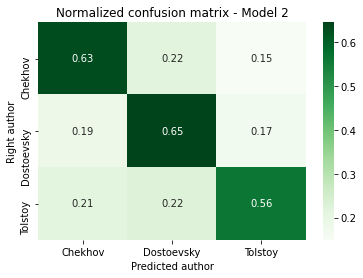

In [73]:
plot_confusion_matrix(confusion, classes=authors_names, \
                      normalize=True, title='Normalized confusion matrix - Model 2')

plt.savefig('confusion_model2.png')

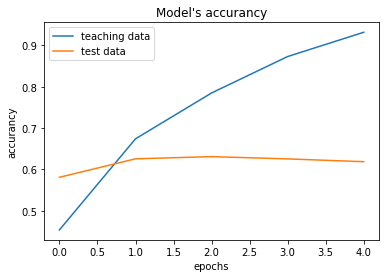

In [74]:
plot_history_of_accurancy(gram3_model2_history)
plt.savefig('accurancy_model2.png')

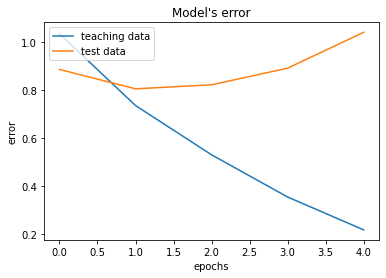

In [75]:
plot_history_of_loss(gram3_model2_history)
plt.savefig('loss_model2.png')

In [76]:
keras.utils.plot_model(gram3_model2, 'gram3_model2_arh.png')

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


# 4*) Benchmarks and comparation

In [77]:
accuracy_list = []
prec_list = []
recall_list = []
f1_list = []

for i in range(10):
    author_pred3 = np.random.choice(authors_names, len(author_test))

    accuracy = accuracy_score(author_test, author_pred3)
    precision, recall, f1, support = score(author_test, author_pred3)
    ave_precision = np.average(precision, weights = support/np.sum(support))
    ave_recall = np.average(recall, weights = support/np.sum(support))
    ave_f1 = np.average(f1, weights = support/np.sum(support))
    
    accuracy_list.append(accuracy)
    prec_list.append(ave_precision)
    recall_list.append(ave_recall)
    f1_list.append(ave_f1)

print('Accurancy:', accuracy_list, np.mean(accuracy_list), np.std(accuracy_list))
print('Average Precision:', prec_list, np.mean(prec_list), np.std(prec_list))
print('Average Recall:', recall_list, np.mean(recall_list), np.std(recall_list))
print('Average F1 Score:', f1_list, np.mean(f1_list), np.std(f1_list))

Accurancy: [0.33075, 0.334, 0.32708333333333334, 0.328, 0.33441666666666664, 0.3383333333333333, 0.32975, 0.334, 0.33316666666666667, 0.33475] 0.332425 0.003284316688614404
Average Precision: [0.33085190837710243, 0.33401052238064466, 0.3272698811766318, 0.328127324687212, 0.3346487371029293, 0.33851232302357154, 0.32986365042926846, 0.33400214396896677, 0.33322706543031516, 0.33472658477555006] 0.33252401413521926 0.0032699346799768014
Average Recall: [0.33075000000000004, 0.334, 0.3270833333333333, 0.328, 0.3344166666666667, 0.3383333333333334, 0.32975, 0.33399999999999996, 0.33316666666666667, 0.33475] 0.332425 0.0032843166886144214
Average F1 Score: [0.3307730370665397, 0.3339836976105784, 0.32711396699034023, 0.3280459727271682, 0.3344503654553463, 0.338356615375229, 0.3297219223483271, 0.3339362480148582, 0.3330336010360224, 0.3347280451165189] 0.33241434717409285 0.0032724824522703017


In [78]:
for i in range(100):
    print('Sentence', i, '- Right answer =', author_test[i],  'Model\'s 1 predict =', author_pred1[i], 
         'Model\'s 2 predict =', author_pred2[i])
    print(text_test[i], '\n')

Sentence 0 - Right answer = Dostoevsky Model's 1 predict = Dostoevsky Model's 2 predict = Dostoevsky
он намекал на ее исцеление об этом конечно говорить еще рано 

Sentence 1 - Right answer = Dostoevsky Model's 1 predict = Chekhov Model's 2 predict = Tolstoy
в то же самое мгновение заметил он что приятель его пробирается уже на крыльцо и вероятно к олсуфью ивановичу 

Sentence 2 - Right answer = Tolstoy Model's 1 predict = Chekhov Model's 2 predict = Chekhov
 ну митрий андреич спаси тебя бог 

Sentence 3 - Right answer = Chekhov Model's 1 predict = Chekhov Model's 2 predict = Chekhov
 откуда же этот экипаж взялся 

Sentence 4 - Right answer = Tolstoy Model's 1 predict = Tolstoy Model's 2 predict = Tolstoy
я правду говору улыбаясь сказал гусар всё о войне через стол прокричал граф 

Sentence 5 - Right answer = Dostoevsky Model's 1 predict = Dostoevsky Model's 2 predict = Dostoevsky
расстается навеки  постой не кричи тетка не любит 

Sentence 6 - Right answer = Tolstoy Model's 1 predict 

In [79]:
def calculate_averages(true, pred, text):
    
    correct_len_chars = []
    incorrect_len_chars = []
    correct_len_words = []
    incorrect_len_words = []

    
    for i in range(len(true)):
        if true[i] == pred[i]:
            correct_len_chars.append(len(text[i]))
            correct_len_words.append(len(text[i].split()))
        else:
            incorrect_len_chars.append(len(text[i]))
            incorrect_len_words.append(len(text[i].split()))
    
    correct_ave_chars = np.mean(correct_len_chars)
    correct_ave_words = np.mean(correct_len_words)
    incorrect_ave_chars = np.mean(incorrect_len_chars)
    incorrect_ave_words = np.mean(incorrect_len_words)
    
    print('t-test for characters')
    print(stats.ttest_ind(correct_len_chars, incorrect_len_chars, equal_var = False))
    
    print('\nt-test for words')
    print(stats.ttest_ind(correct_len_words, incorrect_len_words, equal_var = False))
    
    return correct_ave_chars, correct_ave_words, incorrect_ave_chars, incorrect_ave_words

In [80]:
correct_ave_chars1, correct_ave_words1, incorrect_ave_chars1, incorrect_ave_words1\
= calculate_averages(author_test, author_pred1, text_test)

t-test for characters
Ttest_indResult(statistic=13.100791149616805, pvalue=6.154725368934383e-39)

t-test for words
Ttest_indResult(statistic=12.716836553257187, pvalue=8.39541625242608e-37)


In [81]:
correct_ave_chars2, correct_ave_words2, incorrect_ave_chars2, incorrect_ave_words2\
= calculate_averages(author_test, author_pred2, text_test)

t-test for characters
Ttest_indResult(statistic=14.774104146059196, pvalue=5.970280702831298e-49)

t-test for words
Ttest_indResult(statistic=14.375577701430858, pvalue=1.843813497336129e-46)


In [82]:
print('Model 1 - Average length correct predicted sentences by characters =', correct_ave_chars1, 
        ', incorrect =', incorrect_ave_chars1)
print('Model 2 - Average length correct predicted sentences by characters =', correct_ave_chars2, 
      ', incorrect =', incorrect_ave_chars2)

print('\nModel 1 - Average length correct predicted sentences by words =', correct_ave_words1, 
        ', incorrect =', incorrect_ave_words1)
print('Model 2 - Average length correct predicted sentences by words =', correct_ave_words2, 
      ', incorrect =', incorrect_ave_words2)

Model 1 - Average length correct predicted sentences by characters = 93.35714285714286 , incorrect = 72.11407160699417
Model 2 - Average length correct predicted sentences by characters = 94.01892701525054 , incorrect = 70.39497422680412

Model 1 - Average length correct predicted sentences by words = 15.606170094496942 , incorrect = 12.25
Model 2 - Average length correct predicted sentences by words = 15.71541394335512 , incorrect = 11.971005154639176
